Test the saved CNN models for both datasets

In [10]:
import os
import random
import joblib
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
MODELS_DIR = os.path.join('models', 'all_cnn_models') 
PREPROCESSED_DIR = 'preprocessed_data'
RESULTS_DIR = 'results'
DATA_DIR = 'data'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
cnn_model_configs = {
    "dataset1": "dataset1_best_cnn_blocks_5_dropout_0.3_LR_0.001.h5",
    "dataset2": "dataset2_best_cnn_blocks_5_dropout_0.3_LR_0.001.h5"
}

In [6]:
all_results_list = []

for dataset_name, best_model_filename in cnn_model_configs.items():
    print('\n' + '#'*80)
    print(f'CNN testing started for {dataset_name}')
    print('#'*80)
    
    model_path = os.path.join(MODELS_DIR, best_model_filename)
    data_path = os.path.join(PREPROCESSED_DIR, f"{dataset_name}_processed.npz")
    
    if not os.path.exists(data_path):
        print(f'\n{data_path} not found. please run data_preprocess.ipynb first!')
        continue
    
    model = tf.keras.models.load_model(model_path)
    
    with np.load(data_path, allow_pickle=True) as data:
        images, labels, class_map = data['images'], data['labels'], data['class_map'].item()

    class_names = list(class_map.keys())
    NUM_CLASSES = len(class_names)
    
    images_normalized = images / 255.0
    labels_categorical = to_categorical(labels, num_classes=NUM_CLASSES)
    
    # same random state and split to avoid an input from the training stage
    _, X_test, _, y_test = train_test_split(
        images_normalized, labels_categorical, test_size=0.20, random_state=42, stratify=labels_categorical
    )
    
    print(f'\n{len(X_test)} test data loaded')
    
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    accuracy = report_dict['accuracy']
    
    print(f'\n{best_model_filename} accuracy: {accuracy:.4f}')
    
    params_from_filename = best_model_filename.replace('.h5', '').replace(f'{dataset_name}_', '')
    
    all_results_list.append({
        'Dataset': dataset_name,
        'Model': 'CNN',
        'Best Hyperparameters': params_from_filename,
        'Accuracy': accuracy,
        'F1-Score (Macro)': report_dict['macro avg']['f1-score'],
        'Precision (Macro)': report_dict['macro avg']['precision'],
        'Recall (Macro)': report_dict['macro avg']['recall'],
    })

print('\n\n' + '#'*80)
print("Comparison table for CNN models")
print('#'*80 + '\n')

df_comparison = pd.DataFrame(all_results_list)
df_comparison = df_comparison.sort_values(by=['Dataset', 'Accuracy'], ascending=[True, False])
    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1200)

print(df_comparison.to_string(index=False))


################################################################################
CNN testing started for dataset1
################################################################################



1373 test data loaded
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step

dataset1_best_cnn_blocks_5_dropout_0.3_LR_0.001.h5 accuracy: 0.7873

################################################################################
CNN testing started for dataset2
################################################################################



624 test data loaded
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step

dataset2_best_cnn_blocks_5_dropout_0.3_LR_0.001.h5 accuracy: 0.9071


################################################################################
Comparison table for CNN models
################################################################################

 Dataset Model                   Best Hyperparameters  Accuracy  F1-Score (Macro)  Precision (Macro)  Recall (Macro)
dataset1   CNN best_cnn_blocks_5_dropout_0.3_LR_0.001  0.787327          0.787549           0.800950        0.778895
dataset2   CNN best_cnn_blocks_5_dropout_0.3_LR_0.001  0.907051          0.905891           0.910059        0.905533


Now, let's demonstrate a test for a single image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


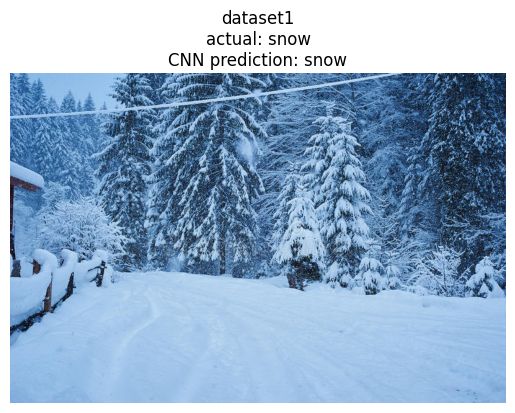

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


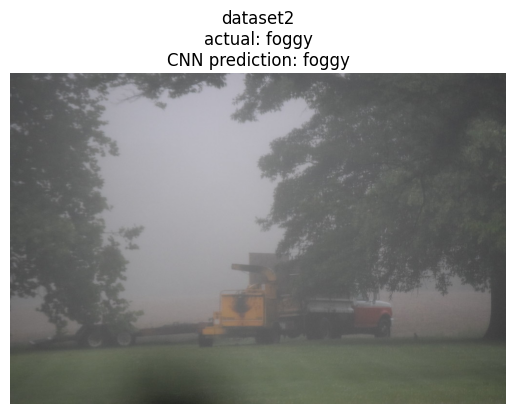

In [21]:
for dataset_name, best_model_filename in cnn_model_configs.items():
    model_path = os.path.join(MODELS_DIR, best_model_filename)
    model = tf.keras.models.load_model(model_path)

    sample_dataset_path = os.path.join(DATA_DIR, dataset_name)
    class_names = [d for d in os.listdir(sample_dataset_path)]
    random_class = random.choice(class_names)

    random_image_name = random.choice(os.listdir(os.path.join(sample_dataset_path, random_class)))
    random_image_path = os.path.join(sample_dataset_path, random_class, random_image_name)

    image = cv2.imread(random_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (128, 128))
    image_normalized = image_resized / 255.0
    image_input = np.expand_dims(image_normalized, axis=0)

    prediction_probs = model.predict(image_input)
    prediction_index = np.argmax(prediction_probs)
    predicted_class = class_names[prediction_index]

    plt.imshow(image_rgb)
    plt.title(f'{dataset_name}\nactual: {random_class}\nCNN prediction: {predicted_class}')
    plt.axis('off')
    plt.show()
    
